In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

import sklearn
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
path = "/content/drive/MyDrive/Crop_recommendation.csv"
crop_reco = pd.read_csv(path)

In [4]:
pip install pyspark


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=f7ffc0e6062192383f21455d43338319ed97bc94f762e6cd61f1592ba8111dde
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [5]:
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.builder.appName("MapReduceExample").getOrCreate()

In [7]:
crop_data_pd = pd.DataFrame(crop_reco)

In [8]:
crop_data_spark = spark.createDataFrame(crop_data_pd)

In [9]:
crop_data_spark

DataFrame[N: bigint, P: bigint, K: bigint, temperature: double, humidity: double, ph: double, rainfall: double, label: string]

In [10]:
crop_data_spark.printSchema()

root
 |-- N: long (nullable = true)
 |-- P: long (nullable = true)
 |-- K: long (nullable = true)
 |-- temperature: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- ph: double (nullable = true)
 |-- rainfall: double (nullable = true)
 |-- label: string (nullable = true)



In [11]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

In [12]:
from pyspark.ml.feature import StringIndexer

In [13]:
crop_data_spark

DataFrame[N: bigint, P: bigint, K: bigint, temperature: double, humidity: double, ph: double, rainfall: double, label: string]

In [14]:

num_unique_crop_types = crop_data_spark.select("label").distinct().count()

In [15]:
print("Number of unique crop types:", num_unique_crop_types)

Number of unique crop types: 22


In [16]:
crop_data_spark.select("label").show()

+-----+
|label|
+-----+
| rice|
| rice|
| rice|
| rice|
| rice|
| rice|
| rice|
| rice|
| rice|
| rice|
| rice|
| rice|
| rice|
| rice|
| rice|
| rice|
| rice|
| rice|
| rice|
| rice|
+-----+
only showing top 20 rows



In [17]:
crop_data_spark


DataFrame[N: bigint, P: bigint, K: bigint, temperature: double, humidity: double, ph: double, rainfall: double, label: string]

In [18]:
df = crop_data_spark.dropna(subset=['label'])

In [19]:
df.printSchema()

root
 |-- N: long (nullable = true)
 |-- P: long (nullable = true)
 |-- K: long (nullable = true)
 |-- temperature: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- ph: double (nullable = true)
 |-- rainfall: double (nullable = true)
 |-- label: string (nullable = true)



In [20]:
from pyspark.sql.functions import col

crop_data = df.drop(col("label"))

In [21]:
crop_data.printSchema()

root
 |-- N: long (nullable = true)
 |-- P: long (nullable = true)
 |-- K: long (nullable = true)
 |-- temperature: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- ph: double (nullable = true)
 |-- rainfall: double (nullable = true)



In [22]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

In [23]:
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

In [24]:
assembler = VectorAssembler(inputCols=features, outputCol="features")

In [25]:

cluster_data = assembler.transform(crop_data)
kmeans = KMeans().setK(3).setSeed(1)

In [26]:
model = kmeans.fit(cluster_data)

In [27]:
predictions = model.transform(cluster_data)

predictions.show()

+---+---+---+-----------+-----------------+------------------+------------------+--------------------+----------+
|  N|  P|  K|temperature|         humidity|                ph|          rainfall|            features|prediction|
+---+---+---+-----------+-----------------+------------------+------------------+--------------------+----------+
| 90| 42| 43|20.87974371|      82.00274423| 6.502985292000001|       202.9355362|[90.0,42.0,43.0,2...|         2|
| 85| 58| 41|21.77046169|      80.31964408|       7.038096361|       226.6555374|[85.0,58.0,41.0,2...|         2|
| 60| 55| 44|23.00445915|       82.3207629|       7.840207144|       263.9642476|[60.0,55.0,44.0,2...|         2|
| 74| 35| 40|26.49109635|      80.15836264|       6.980400905|       242.8640342|[74.0,35.0,40.0,2...|         2|
| 78| 42| 42|20.13017482|      81.60487287|       7.628472891|       262.7173405|[78.0,42.0,42.0,2...|         2|
| 69| 37| 42|23.05804872|      83.37011772|       7.073453503|       251.0549998|[69.0,3

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

In [29]:
pandas_df = predictions.select('features', 'prediction').toPandas()

In [30]:
features_list = [Vectors.dense(row) for row in pandas_df['features']]

In [31]:
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(predictions)
transformed_data = pca_model.transform(predictions)


In [32]:
transformed_df = transformed_data.select('pca_features', 'prediction').toPandas()


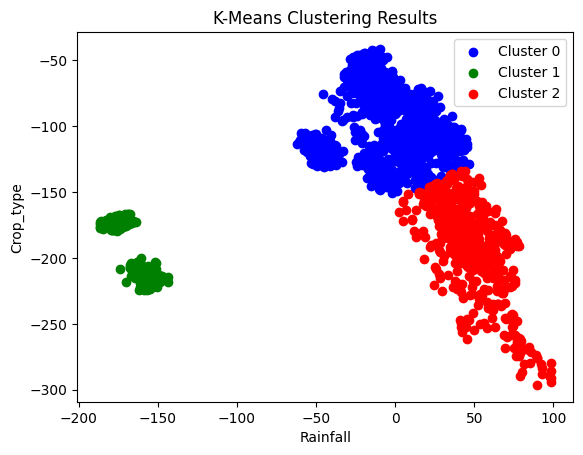

In [33]:
fig, ax = plt.subplots()
colors = ['blue', 'green', 'red']
for i in range(3):
    subset = transformed_df[transformed_df['prediction'] == i]
    ax.scatter(subset['pca_features'].apply(lambda x: x[0]), subset['pca_features'].apply(lambda x: x[1]), c=colors[i], label=f"Cluster {i}")
ax.legend()
ax.set_xlabel('Rainfall')
ax.set_ylabel('Crop_type')
ax.set_title('K-Means Clustering Results')
plt.show()

In [37]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Extract the features column from the dataset
features_df = transformed_data.select("features")

# Try different values of K and compute the silhouette score
best_k = -1
best_score = -1
for k in range(2, 10):
    kmeans = KMeans(k=k, seed=1)
    model = kmeans.fit(features_df)
    predictions = model.transform(features_df)
    evaluator = ClusteringEvaluator()
    score = evaluator.evaluate(predictions)
    print(f"K={k}, silhouette score={score:.4f}")
    if score > best_score:
        best_k = k
        best_score = score

# Fit the final K-means model with the best value of K
kmeans = KMeans(k=best_k, seed=1)
model = kmeans.fit(features_df)
predictions = model.transform(features_df)

# Evaluate the final K-means model with other metrics
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
inertia = model.summary.trainingCost
print(f"Best K={best_k}, silhouette score={silhouette:.4f}, inertia={inertia:.4f}")


K=2, silhouette score=0.4069
K=3, silhouette score=0.6121
K=4, silhouette score=0.5724
K=5, silhouette score=0.5526
K=6, silhouette score=0.4751
K=7, silhouette score=0.6057
K=8, silhouette score=0.6430
K=9, silhouette score=0.6342
Best K=8, silhouette score=0.6430, inertia=2727858.0938


K=2, WSS=13955102.9680
K=3, WSS=7423978.8728
K=4, WSS=5337376.6199
K=5, WSS=4763582.7448
K=6, WSS=4873120.5069
K=7, WSS=3104005.1894
K=8, WSS=2727858.0938
K=9, WSS=2374170.6982


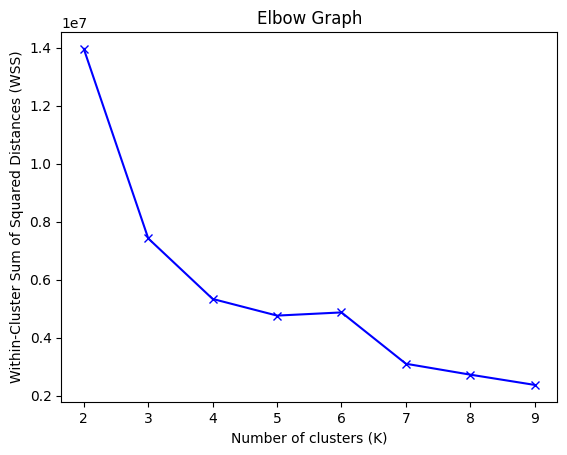

In [38]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Extract the features column from the dataset
features_df = transformed_data.select("features")

# Try different values of K and compute the WSS
wss_list = []
for k in range(2, 10):
    kmeans = KMeans(k=k, seed=1)
    model = kmeans.fit(features_df)
    wss = model.summary.trainingCost
    print(f"K={k}, WSS={wss:.4f}")
    wss_list.append(wss)

# Plot the elbow graph
plt.plot(range(2, 10), wss_list, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squared Distances (WSS)')
plt.title('Elbow Graph')
plt.show()
